In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sb
import pandas as pd
import epidemic_model_classes_numba as epi_mod
from scipy.integrate import odeint
import scipy.stats as st
from scipy.stats import pearsonr
import os
from tqdm import tqdm

In [40]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

country = "Brazil"
country_file_name = "brazil"
window_size = 30

log_flat = []
log_past = []

folders = os.listdir("../logs/sdumont")
folders.sort()
folders

for folder in folders:
    if "adaptive" in folder and "3_posts" in folder and country in folder and f"{window_size}_day" in folder :
        if "True" in folder:
            log_past.append("../logs/sdumont/"+folder+"/")
        else:
            log_flat.append("../logs/sdumont/"+folder+"/")

In [41]:
log_past = log_past[:20]
print(len(log_past))
log_past

20


['../logs/sdumont/log2021-08-24_19-43-43_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_20-16-27_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_20-48-26_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_21-21-10_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_21-48-32_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_21-28-25_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_21-59-42_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_22-34-52_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_23-09-46_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/sdumont/log2021-10-03_23-43-41_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_True/',
 '../logs/

In [42]:
log_flat = log_flat[:20]
print(len(log_flat))
log_flat

20


['../logs/sdumont/log2021-08-24_22-20-44_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_22-23-07_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_22-25-32_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_22-28-04_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-08-24_22-30-20_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-04_00-13-33_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-04_00-16-05_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-04_00-18-31_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-04_00-20-54_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',
 '../logs/sdumont/log2021-10-04_00-23-29_adaptive_Brazil_SEIRD2_3_posts_30_day-window_past_False/',


In [43]:
if country not in os.listdir("paper_daora"):
    os.mkdir(f"paper_daora/{country}")
if str(window_size) not in os.listdir(f"paper_daora/{country}"):
    os.mkdir(f"paper_daora/{country}/{str(window_size)}")

In [44]:
n_post = len(os.listdir(log_flat[0]))-1
days_folders = os.listdir(log_flat[0]+f"/Posterior1/{country}/SEIRD2")
for i in range(len(days_folders)):
    days_folders[i] = int(days_folders[i].split("_")[0])
days_folders.sort()
n_window = len(days_folders)

print(n_post)
print(n_window)
print(days_folders)

3
76
[30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405]


In [45]:
seird = epi_mod.SEIRD2

In [46]:
x_dat_flat = np.empty((len(log_flat), n_window), dtype=object)
y_fit_flat = np.empty((len(log_flat), n_window), dtype=object)
y_pred_flat = np.zeros((len(log_flat), n_window, 10, 2))

x_dat_past = np.empty((len(log_past), n_window), dtype=object)
y_fit_past = np.empty((len(log_past), n_window), dtype=object)
y_pred_past = np.zeros((len(log_past), n_window, 10, 2))

flat_params = np.zeros((len(log_flat), n_window, 8))
rmsd_flat_fit = np.zeros((len(log_flat), n_window))
rmsd_flat_pred = np.zeros((len(log_flat), n_window))
rmsd_flat_list = np.zeros((len(log_flat), n_window, 10, 2))
flat_tolerances = np.zeros((len(log_flat), n_post, n_window))

past_params = np.zeros((len(log_flat), n_window, 8))
rmsd_past_fit = np.zeros((len(log_flat), n_window))
rmsd_past_pred = np.zeros((len(log_flat), n_window))
rmsd_past_list = np.zeros((len(log_flat), n_window, 10, 2))
past_tolerances = np.zeros((len(log_flat), n_post, n_window))

post_flat_size = np.zeros((len(log_flat), n_window), dtype=np.int64)
post_past_size = np.zeros((len(log_past), n_window), dtype=np.int64)

In [47]:
for log_idx in range(len(log_flat)):
    for window in tqdm(range(n_window)):
        data = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")
        for i in range(1, data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] < data[i-1,j]:
                    data[i,j] = data[i-1,j]
        np.savetxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt", data)
        
        x_dat_flat[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:,0]
        y_fit_flat[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:-10,1:]
        y_pred_flat[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[-10:,1:]
        
        log = open(log_flat[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
        rmsd_flat_list[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/val_error.txt")
        flat_params[log_idx, window] = np.loadtxt(log_flat[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/best_params.txt")
        log_text = log.read().split("\n")
        
        for line in log_text:
            if "Weighted RMSD:" in line:
                rmsd_flat_fit[log_idx, window] = float(line.split(" ")[-1])
            if "RMSD for validation data:" in line:
                rmsd_flat_pred[log_idx, window] = float(line.split(" ")[-1])
            if "Training window size:" in line:
                    post_flat_size[log_idx, window] = int(line.split(" ")[-1])
        
        for post in range(n_post):
            log = open(log_flat[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
            
            log_text = log.read().split("\n")
            
            for line in log_text:
                if "Tolerance:" in line:
                    flat_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
            log = open(log_flat[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")

            for line in log_text:
                if "Tolerance:" in line:
                    flat_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
for log_idx in range(len(log_past)):
    for window in tqdm(range(n_window)):
        data = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")
        for i in range(1, data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] < data[i-1,j]:
                    data[i,j] = data[i-1,j]
        np.savetxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt", data)
        
        x_dat_past[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:,0]
        y_fit_past[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:-10,1:]
        y_pred_past[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[-10:,1:]
        
        log = open(log_past[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
        rmsd_past_list[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/val_error.txt")
        past_params[log_idx, window] = np.loadtxt(log_past[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/best_params.txt")
        log_text = log.read().split("\n")
        
        for line in log_text:
            if "Weighted RMSD:" in line:
                rmsd_past_fit[log_idx, window] = float(line.split(" ")[-1])
            if "RMSD for validation data:" in line:
                rmsd_past_pred[log_idx, window] = float(line.split(" ")[-1])
            if "Training window size:" in line:
                post_past_size[log_idx, window] = int(line.split(" ")[-1])
        
        for post in range(n_post):
            log = open(log_past[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
            
            log_text = log.read().split("\n")
            
            for line in log_text:
                if "Tolerance:" in line:
                    past_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
            log = open(log_past[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")

            for line in log_text:
                if "Tolerance:" in line:
                    past_tolerances[log_idx, post, window] = float(line.split(" ")[-1])

100%|██████████████████████████████████████████| 76/76 [00:00<00:00, 449.08it/s]


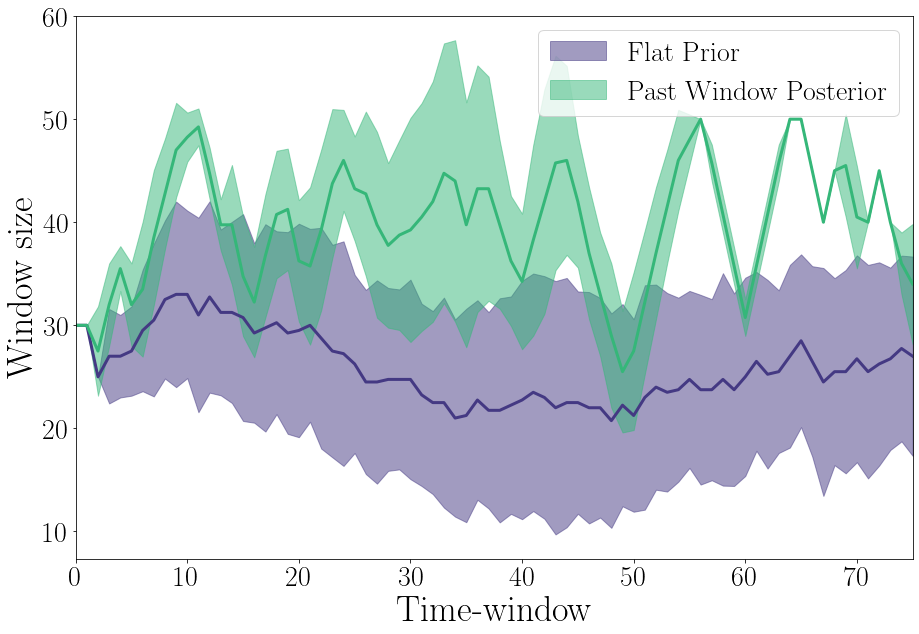

In [48]:
plt.figure(figsize=(15,10))
plt.plot(np.mean(post_flat_size, axis=0), lw=3, color=sb.color_palette("viridis", 5)[0])
plt.fill_between(np.arange(n_window), np.mean(post_flat_size, axis=0)-np.std(post_flat_size, axis=0), np.mean(post_flat_size, axis=0)+np.std(post_flat_size, axis=0), color=sb.color_palette("viridis", 5)[0], label="Flat Prior", alpha=0.5)

plt.plot(np.mean(post_past_size, axis=0), lw=3, color=sb.color_palette("viridis", 5)[3])
plt.fill_between(np.arange(n_window), np.mean(post_past_size, axis=0)-np.std(post_past_size, axis=0), np.mean(post_past_size, axis=0)+np.std(post_past_size, axis=0), color=sb.color_palette("viridis", 5)[3], label="Past Window Posterior", alpha=0.5)

plt.legend(fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlim(0, n_window-1)
plt.xlabel("Time-window", fontsize=36)
plt.ylabel("Window size", fontsize=36)
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_window_size.png", dpi=300, bbox_inches="tight")

In [33]:
print(np.mean(np.std(post_flat_size, axis=0)))
print(np.mean(np.std(post_past_size, axis=0)))

9.01807134851833
5.348731412395401


Flat 0.1449618335526316
Past 0.01715694407894737


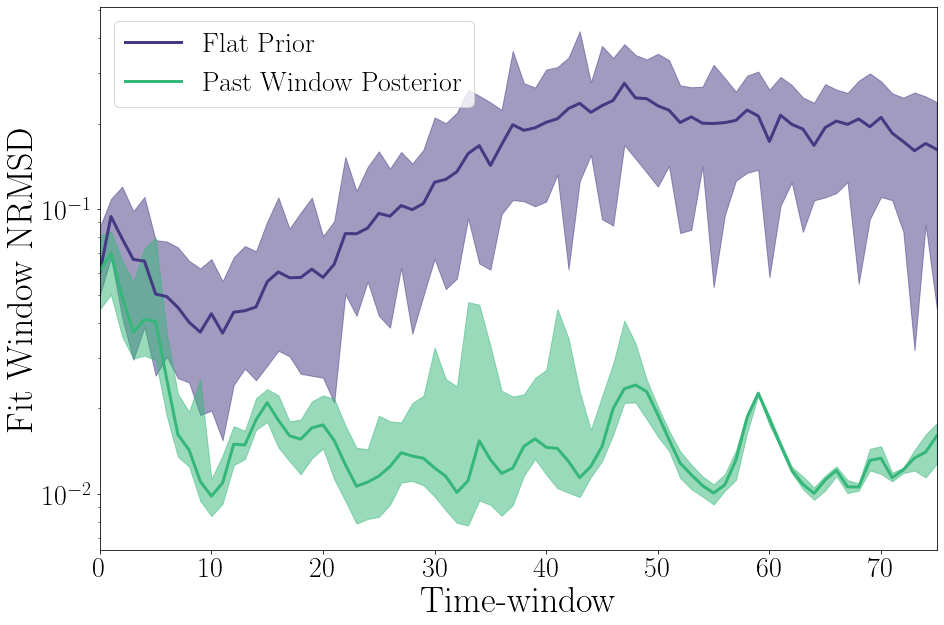

In [70]:
plt.figure(figsize=(15,10))
plt.plot(np.mean(rmsd_flat_fit, axis=0), lw=3, color=sb.color_palette("viridis", 5)[0], label="Flat Prior")
plt.fill_between(np.arange(len(rmsd_flat_fit[0])), np.min(rmsd_flat_fit, axis=0), np.max(rmsd_flat_fit, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[0])
plt.plot(np.mean(rmsd_past_fit, axis=0), lw=3, color=sb.color_palette("viridis", 5)[3], label="Past Window Posterior")
plt.fill_between(np.arange(len(rmsd_flat_fit[0])), np.min(rmsd_past_fit, axis=0), np.max(rmsd_past_fit, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[3])
plt.legend(loc="upper left", fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlim(0, n_window-1)
plt.xlabel("Time-window", fontsize=36)
plt.ylabel("Fit Window NRMSD", fontsize=36)
plt.yscale("log")
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_fit_window_nrmsd.png", dpi=300, bbox_inches="tight")
print("Flat", np.mean(rmsd_flat_fit))
print("Past", np.mean(rmsd_past_fit))

Flat 1.032020842105263
Past 0.2616685822368421


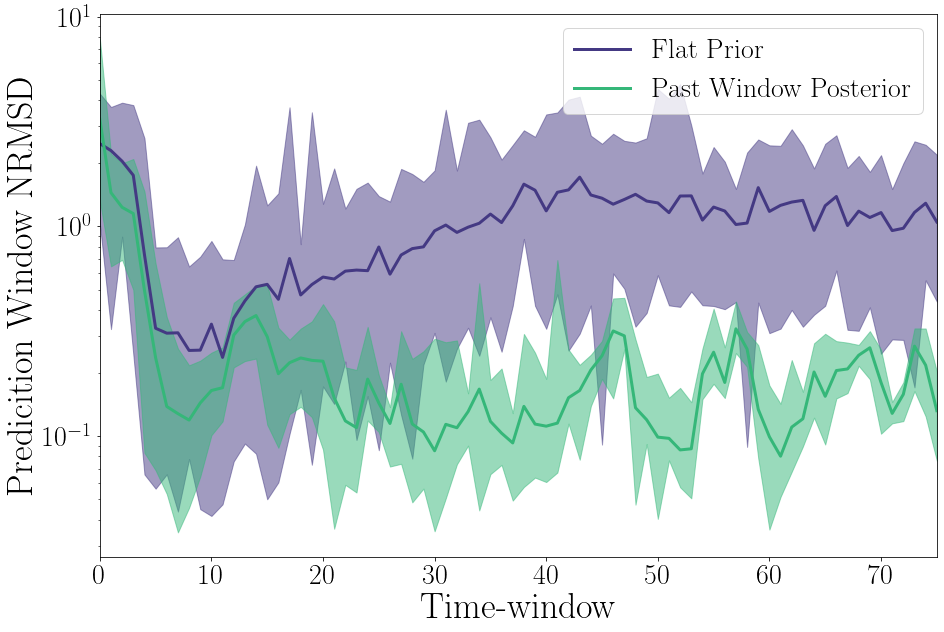

In [69]:
plt.figure(figsize=(15, 10))
plt.plot(np.mean(rmsd_flat_pred, axis=0), lw=3, color=sb.color_palette("viridis", 5)[0], label="Flat Prior")
plt.fill_between(np.arange(len(rmsd_flat_pred[0])), np.min(rmsd_flat_pred, axis=0), np.max(rmsd_flat_pred, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[0])
plt.plot(np.mean(rmsd_past_pred, axis=0), lw=3, color=sb.color_palette("viridis", 5)[3], label="Past Window Posterior")
plt.fill_between(np.arange(len(rmsd_flat_pred[0])), np.min(rmsd_past_pred, axis=0), np.max(rmsd_past_pred, axis=0), alpha=0.5, color=sb.color_palette("viridis", 5)[3])
plt.legend(loc="upper right", fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlim(0, n_window-1)
plt.xlabel("Time-window", fontsize=36)
plt.ylabel("Predicition Window NRMSD", fontsize=36)
plt.yscale("log")
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_pred_window_nrmsd.png", dpi=300, bbox_inches="tight")
print("Flat", np.mean(rmsd_flat_pred))
print("Past", np.mean(rmsd_past_pred))

In [12]:
rmsd_flat_list_norm = np.abs((y_pred_flat[:,:,1:]-rmsd_flat_list[:,:,1:])-(y_pred_flat[:,:,:-1]-rmsd_flat_list[:,:,:-1])-(y_pred_flat[:,:,1:]-y_pred_flat[:,:,:-1]))/(y_pred_flat[:,:,1:]-y_pred_flat[:,:,:-1]+1)
rmsd_past_list_norm = np.abs((y_pred_past[:,:,1:]-rmsd_past_list[:,:,1:])-(y_pred_past[:,:,:-1]-rmsd_past_list[:,:,:-1])-(y_pred_past[:,:,1:]-y_pred_past[:,:,:-1]))/(y_pred_past[:,:,1:]-y_pred_past[:,:,:-1]+1)

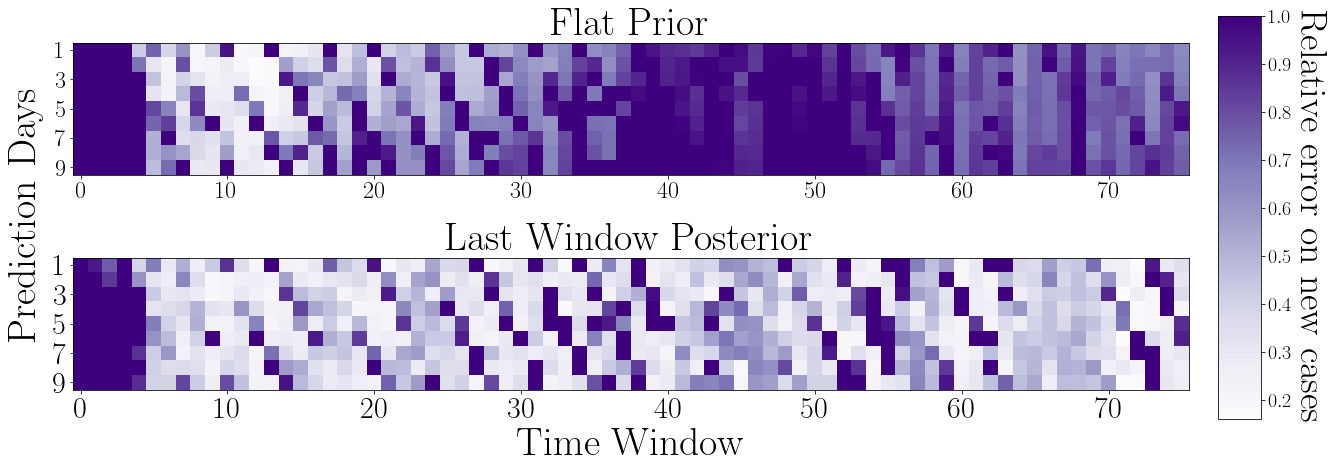

In [22]:
# plt.rcParams.update({"font.size":36})
fig = plt.figure(figsize=(20,7))
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,1)
pl = plt.imshow(np.mean(rmsd_flat_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples")
plt.yticks(range(0,10,2), labels=range(1,11,2), fontsize=24)
plt.xticks(fontsize=24)
plt.title("Flat Prior", fontsize=40)
plt.subplot(2,1,2)
plt.imshow(np.mean(rmsd_past_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples")
plt.yticks(range(0,10,2), labels=range(1,11,2), fontsize=30)
plt.xticks(fontsize=30)
plt.title("Last Window Posterior", fontsize=40)
plt.xlabel("Time Window", fontsize=40)
plt.text(-5, 4.7, "Prediction Days", rotation="vertical", fontsize=40)
cb_ax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
cb = fig.colorbar(pl, cax=cb_ax)
cb.set_label("Relative error on new cases", rotation=-90, labelpad=35, fontsize=38)
cb.ax.tick_params(labelsize=20)
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_heatmap.png", dpi=300, bbox_inches="tight")

In [19]:
pearsonr(rmsd_flat_fit.flatten(), rmsd_flat_pred.flatten())

(0.45257139570024657, 1.2804383631234011e-77)

In [20]:
pearsonr(rmsd_past_fit.flatten(), rmsd_past_pred.flatten())

(0.7054002454382822, 3.681829955339688e-229)

---

# Subplots - Windows

In [49]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')

plt.subplots(int(np.ceil(n_window/8)), 8, figsize=(16, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.2)

y0 = np.zeros(5)

for i in range(n_window, int(np.ceil(n_window/8))*8):
    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.axis("off")

for i in tqdm(range(n_window)):
    y_fit = np.zeros((len(log_flat), 60))
    x_len = 0
    x_max_len_idx = -1
    
    for log_idx in range(len(log_flat)):
        if len(x_dat_flat[log_idx, i]) > x_len:
            x_len = len(x_dat_flat[log_idx, i])
            x_max_length_idx = log_idx
        
        y0[-1] = y_fit_flat[log_idx, i][0,1]
        y0[-2] = y_fit_flat[log_idx, i][0,0] - y0[-1]
        
        y_fit[log_idx,-len(x_dat_flat[log_idx, i]):] = seird.infected_dead(x_dat_flat[log_idx, i], flat_params[log_idx, i], y0)[0]
    
    y_fit_avg = np.zeros(x_len)
    y_fit_std = np.zeros(x_len)
    
    for j in range(x_len):
        y = []
        for k in range(len(log_flat)):
            if y_fit[k,j-x_len] != 0:
                y.append(y_fit[k,j-x_len])
        y_fit_avg[j] = np.mean(y)
        y_fit_std[j] = np.std(y)

    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.plot(x_dat_flat[x_max_length_idx, i][:-10], y_fit_flat[x_max_length_idx, i][:,0], "o", ms=1, c="k")
    plt.plot(x_dat_flat[x_max_length_idx, i][-10:], y_pred_flat[x_max_length_idx, i,:,0], "o", ms=1, c="#808080")
    plt.ticklabel_format(axis="y", scilimits=(0,1))
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.gca().yaxis.get_offset_text().set_fontsize(4)
    
    plt.title(f"Time-window {x_dat_flat[x_max_length_idx, i][0]:.0f}-{x_dat_flat[x_max_length_idx, i][-1]:.0f}", fontsize=8)
    
    plt.plot(x_dat_flat[x_max_length_idx, i], y_fit_avg, lw=1)
    plt.fill_between(x_dat_flat[x_max_length_idx, i], y_fit_avg-y_fit_std, y_fit_avg+y_fit_std, alpha=0.3)
    
    plt.vlines(np.mean(x_dat_flat[x_max_length_idx, i][-11:-9]), y_fit_flat[x_max_length_idx, i][0,0], max(y_pred_flat[x_max_length_idx, i,-1,0], y_fit_avg[-1]+y_fit_std[-1]), color="#202020", ls="--", lw=1)
    
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_windows_flat.png", dpi=300, bbox_inches="tight")
plt.close()

100%|███████████████████████████████████████████| 76/76 [00:01<00:00, 57.06it/s]


In [50]:
plt.subplots(int(np.ceil(n_window/8)), 8, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

y0 = np.zeros(5)

for i in range(n_window, int(np.ceil(n_window/8))*8):
    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.axis("off")

for i in tqdm(range(n_window)):
    y_fit = np.zeros((len(log_past), 60))
    x_len = 0
    x_max_len_idx = -1
    
    for log_idx in range(len(log_past)):
        if len(x_dat_past[log_idx, i]) > x_len:
            x_len = len(x_dat_past[log_idx, i])
            x_max_length_idx = log_idx
        
        y0[-1] = y_fit_past[log_idx, i][0,1]
        y0[-2] = y_fit_past[log_idx, i][0,0] - y0[-1]
        
        y_fit[log_idx,-len(x_dat_past[log_idx, i]):] = seird.infected_dead(x_dat_past[log_idx, i], past_params[log_idx, i], y0)[0]
    
    y_fit_avg = np.zeros(x_len)
    y_fit_std = np.zeros(x_len)
    
    for j in range(x_len):
        y = []
        for k in range(len(log_past)):
            if y_fit[k,j-x_len] != 0:
                y.append(y_fit[k,j-x_len])
        y_fit_avg[j] = np.mean(y)
        y_fit_std[j] = np.std(y)

    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.plot(x_dat_past[x_max_length_idx, i][:-10], y_fit_past[x_max_length_idx, i][:,0], "o", ms=1, c="k")
    plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_pred_past[x_max_length_idx, i, :,0], "o", ms=1, c="#808080")
    plt.ticklabel_format(axis="y", scilimits=(0,1))
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.gca().yaxis.get_offset_text().set_fontsize(4)
    
    plt.title(f"Time-window {x_dat_past[x_max_length_idx, i][0]:.0f}-{x_dat_past[x_max_length_idx, i][-1]:.0f}", fontsize=8)
    
    plt.plot(x_dat_past[x_max_length_idx, i], y_fit_avg, lw=1)
    plt.fill_between(x_dat_past[x_max_length_idx, i], y_fit_avg-y_fit_std, y_fit_avg+y_fit_std, alpha=0.3)
    
    plt.vlines(np.mean(x_dat_past[x_max_length_idx, i][-11:-9]), y_fit_past[x_max_length_idx, i][0,0], max(y_pred_past[x_max_length_idx, i,-1,0], y_fit_avg[-1]+y_fit_std[-1]), color="#202020", ls="--", lw=1)

plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_windows_past.png", dpi=300, bbox_inches="tight")
plt.close()

100%|███████████████████████████████████████████| 76/76 [00:01<00:00, 56.76it/s]


In [11]:
n_split = 4

plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3)

y0 = np.zeros(5)

for split in range(n_split):
    if split != n_split-1:
        rng = [int(n_window/n_split*split), int(n_window/n_split*(split+1))]
    
    else:
        rng = [int(n_window/n_split*split), n_window]
    
    plt.subplot(2, 2, split+1)
    
    x_dat = []
    y_dat = []
    
    for i in tqdm(range(*rng)):
    # for i in tqdm(range(10)):
        y_fit = np.zeros((len(log_past), 60))
        x_len = 0
        x_max_len_idx = -1
        # print(i)

        for log_idx in range(len(log_past)):
            if len(x_dat_past[log_idx, i]) > x_len:
                x_len = len(x_dat_past[log_idx, i])
                x_max_length_idx = log_idx

            y0[-1] = y_fit_past[log_idx, i][0,1]
            y0[-2] = y_fit_past[log_idx, i][0,0] - y0[-1]

            y_fit[log_idx,-len(x_dat_past[log_idx, i]):] = seird.infected_dead(x_dat_past[log_idx, i], past_params[log_idx, i], y0)[0]

        y_fit_avg = np.zeros(x_len)
        y_fit_std = np.zeros(x_len)

        for j in range(x_len):
            y = []
            for k in range(len(log_past)):
                if y_fit[k,j-x_len] != 0:
                    y.append(y_fit[k,j-x_len])
            y_fit_avg[j] = np.mean(y)
            y_fit_std[j] = np.std(y)
        
        # plt.plot(x_dat_past[x_max_length_idx, i][:-10], y_fit_past[x_max_length_idx, i][:,0], "o", ms=3, c="gray", alpha=0.5)
        # plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_pred_past[x_max_length_idx, i, :,0], "o", ms=3, c="gray", alpha=0.8)
        if split == n_split-1 and i == rng[0]:
            plt.scatter(x_dat_past[x_max_length_idx, i][-10:-5], y_pred_past[x_max_length_idx, i, :,0][:-5], s=50, facecolors="w", edgecolors="k", label="Data")
        else:
            plt.scatter(x_dat_past[x_max_length_idx, i][-10:-5], y_pred_past[x_max_length_idx, i, :,0][:-5], s=50, facecolors="w", edgecolors="k")
        plt.ticklabel_format(axis="y", scilimits=(0,1))
        plt.xlabel("Day", fontsize=24)
        plt.ylabel("Cumulative cases", fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.gca().yaxis.get_offset_text().set_fontsize(18)

        if split == n_split-1 and i == rng[0]:
            plt.plot(x_dat_past[x_max_length_idx, i][-10:-5], y_fit_avg[-10:-5], lw=3, c=sb.color_palette("viridis", 10)[4], zorder=3, label="Prediction")
            plt.fill_between(x_dat_past[x_max_length_idx, i][-10:-5], (y_fit_avg-y_fit_std)[-10:-5], (y_fit_avg+y_fit_std)[-10:-5], color=sb.color_palette("viridis", 10)[4], alpha=0.5)
            plt.legend(loc=(-0.21, 1.07), fontsize=18)
        else:
            if split == n_split-1 and i == rng[-1]-1:
                plt.scatter(x_dat_past[x_max_length_idx, i][-5:], y_pred_past[x_max_length_idx, i, :,0][-5:], s=50, facecolors="w", edgecolors="k")
                plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_fit_avg[-10:], lw=3, c=sb.color_palette("viridis", 10)[4], zorder=3)
                plt.fill_between(x_dat_past[x_max_length_idx, i][-10:], (y_fit_avg-y_fit_std)[-10:], (y_fit_avg+y_fit_std)[-10:], color=sb.color_palette("viridis", 10)[4], alpha=0.5)
            else:
                plt.plot(x_dat_past[x_max_length_idx, i][-10:-5], y_fit_avg[-10:-5], lw=3, c=sb.color_palette("viridis", 10)[4], zorder=3)
                plt.fill_between(x_dat_past[x_max_length_idx, i][-10:-5], (y_fit_avg-y_fit_std)[-10:-5], (y_fit_avg+y_fit_std)[-10:-5], color=sb.color_palette("viridis", 10)[4], alpha=0.5)
    
#         x_dat.append(x_dat_past[x_max_length_idx, i][-10:-5])
#         y_dat.append(y_pred_past[x_max_length_idx, i, :,0][:-5])
    
#     plt.plot(np.concatenate(x_dat), np.concatenate(y_dat), lw=3, c="k")
    
    if split != n_split-1:
        plt.title(f"Days {x_dat_past[x_max_length_idx, rng[0]][-10]:.0f}-{x_dat_past[x_max_length_idx, rng[-1]-1][-5]-1:.0f}", fontsize=26)
        plt.xlim(x_dat_past[x_max_length_idx, rng[0]][-10], x_dat_past[x_max_length_idx, rng[-1]-1][-5]-1)
    else:
        plt.title(f"Days {x_dat_past[x_max_length_idx, rng[0]][-10]:.0f}-{x_dat_past[x_max_length_idx, rng[-1]-1][-1]:.0f}", fontsize=26)
        plt.xlim(x_dat_past[x_max_length_idx, rng[0]][-10], x_dat_past[x_max_length_idx, rng[-1]-1][-1])
        
# plt.show()
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_5day_pred_past.png", dpi=300, bbox_inches="tight")
plt.close()

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 31.24it/s]


In [12]:
n_split = 4

fig, ax = plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3)

y0 = np.zeros(5)

for split in range(n_split):
    if split != n_split-1:
        rng = [int(n_window/n_split*split), int(n_window/n_split*(split+1))]
    
    else:
        rng = [int(n_window/n_split*split), n_window]
    
    if split > 0 and split % 2 and int(n_window/n_split)%2 == 1:
        rng[0] += 1
    
    for i in tqdm(range(*rng,2)):
    # for i in tqdm(range(10)):
        y_fit = np.zeros((len(log_past), 60))
        x_len = 0
        x_max_len_idx = -1
        # print(i)

        for log_idx in range(len(log_past)):
            if len(x_dat_past[log_idx, i]) > x_len:
                x_len = len(x_dat_past[log_idx, i])
                x_max_length_idx = log_idx

            y0[-1] = y_fit_past[log_idx, i][0,1]
            y0[-2] = y_fit_past[log_idx, i][0,0] - y0[-1]

            y_fit[log_idx,-len(x_dat_past[log_idx, i]):] = seird.infected_dead(x_dat_past[log_idx, i], past_params[log_idx, i], y0)[0]

        y_fit_avg = np.zeros(x_len)
        y_fit_std = np.zeros(x_len)

        for j in range(x_len):
            y = []
            for k in range(len(log_past)):
                if y_fit[k,j-x_len] != 0:
                    y.append(y_fit[k,j-x_len])
            y_fit_avg[j] = np.mean(y)
            y_fit_std[j] = np.std(y)
        
        
        plt.subplot(2, 2, split+1)
        # plt.plot(x_dat_past[x_max_length_idx, i][:-10], y_fit_past[x_max_length_idx, i][:,0], "o", ms=3, c="gray", alpha=0.5)
        # plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_pred_past[x_max_length_idx, i, :,0], "o", ms=3, c="gray", alpha=0.8)
        if split == n_split-1 and i == rng[0]:
            plt.scatter(x_dat_past[x_max_length_idx, i][-10:], y_pred_past[x_max_length_idx, i, :,0][:], s=50, facecolors="w", edgecolors="k", label="Data")
        else:
            plt.scatter(x_dat_past[x_max_length_idx, i][-10:], y_pred_past[x_max_length_idx, i, :,0][:], s=50, facecolors="w", edgecolors="k")
        plt.ticklabel_format(axis="y", scilimits=(0,1))
        plt.xlabel("Day", fontsize=24)
        plt.ylabel("Cumulative cases", fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.gca().yaxis.get_offset_text().set_fontsize(18)
        
        if split == n_split-1 and i == rng[0]:
            plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_fit_avg[-10:], lw=3, c=sb.color_palette("viridis", 10)[4], zorder=3, label="Prediction")
            plt.legend(loc=(-0.23, 1.07), fontsize=18)
        else:
            plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_fit_avg[-10:], lw=3, c=sb.color_palette("viridis", 10)[4], zorder=3)
        plt.fill_between(x_dat_past[x_max_length_idx, i][-10:], (y_fit_avg-y_fit_std)[-10:], (y_fit_avg+y_fit_std)[-10:], color=sb.color_palette("viridis", 10)[4], alpha=0.5)
        
        if split%2 != 0:
            plt.title(f"Days {x_dat_past[x_max_length_idx, rng[0]][-10]:.0f}-{x_dat_past[x_max_length_idx, rng[-1]-1][-5]-1:.0f}", fontsize=26)
            plt.xlim(x_dat_past[x_max_length_idx, rng[0]][-10], x_dat_past[x_max_length_idx, rng[-1]-1][-5]-1)
        else:
            plt.title(f"Days {x_dat_past[x_max_length_idx, rng[0]][-10]:.0f}-{x_dat_past[x_max_length_idx, rng[-1]-1][-1]:.0f}", fontsize=26)
            plt.xlim(x_dat_past[x_max_length_idx, rng[0]][-10], x_dat_past[x_max_length_idx, rng[-1]-1][-1])
        
# plt.show()
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_10day_pred_past.png", dpi=300, bbox_inches="tight")
plt.close()

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 34.05it/s]
